In [1]:
import pandas as pd
import numpy as np
import datetime

# Set the parameter to the value expected
`mh_damage` should be the average damage on character sheet and `oh_damage` is the average damage with dual wield damage penalty and dual wield spec talent.

`mh_crit_threshold` is the expected damage threshold for an auto MH crit and `ww_crit_threshold` is for WW MH. These value should be set higher than the maximum value of OH crit.

In [2]:
#insert your log file here
log_file_path = "full-rotation-ptr.txt"

# full-rotation-ptr.txt value
mh_damage = (1944+2315) / 2
oh_damage = (1944+2315) / 2 * 0.5 *125/100
mh_crit_threshold = 2500
ww_crit_threshold = 4000

In [328]:
#insert your log file here
log_file_path = "multi-target-ptr.txt"

# multi-target-ptr.txt value
mh_damage = (903+906) / 2
oh_damage = (903+906) / 2 * 0.5 *125/100
mh_crit_threshold = 1000
ww_crit_threshold = 1200


In [30]:
cols = [i for i in range(39)]
df = pd.read_csv(log_file_path, header=None, names=cols, delimiter='  |,')
log_events_filter = ['SWING_DAMAGE_LANDED', 'SPELL_DAMAGE']
df['Timestamp'] = df[0]
df['Actor'] = df[2]
df['Target'] = np.where(pd.to_numeric(df[13], errors='coerce').notna(), df[10], df[13])
df['Spell'] = df[11].astype(str).str.strip().str.replace(r'^"(.*)"$', r'\1')
df['White Damage'] = df[26]
df['White Crit'] = df[33]
df['Yellow Damage'] = df[29]
df['Yellow Crit'] = df[36]
df = df[df[1].isin(log_events_filter)]
df=df[['Timestamp', 'Actor', 'Target', 'Spell', 'White Damage', 'White Crit', 'Yellow Damage', 'Yellow Crit']]
df['Spell'] = np.where((df['Spell'] == '0000000000000000') & (df['White Damage'] >= mh_crit_threshold) & (df['White Crit'] == '1'),
                       "Melee MH Crit", df['Spell'])
df['Spell'] = np.where((df['Spell'] == '0000000000000000') & (df['White Damage'] < mh_crit_threshold) & (df['White Crit'] == '1'),
                       "Melee OH Crit", df['Spell'])
df

C:\Users\GroxEmpire\AppData\Local\Temp\ipykernel_26572\223583278.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(log_file_path, header=None, names=cols, delimiter='  |,')
C:\Users\GroxEmpire\AppData\Local\Temp\ipykernel_26572\223583278.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Spell'] = df[11].astype(str).str.strip().str.replace(r'^"(.*)"$', r'\1')


,Timestamp,Actor,Target,Spell,White Damage,White Crit,Yellow Damage,Yellow Crit
4,5/8 16:07:08.073,Player-4904-00822A31,Creature-0-4908-571-18024-33229-0000586B7B,0000000000000000,1473.0,nil,1.0,None
11,5/8 16:07:09.273,Player-4904-00822A31,Creature-0-4908-571-18024-33229-0000586B7B,Bloodthirst,118.0,0,1822.0,nil
16,5/8 16:07:09.273,Player-4904-00822A31,Creature-0-4908-571-18024-33229-0000586B7B,0000000000000000,983.0,nil,1.0,None
28,5/8 16:07:11.052,Player-4904-00822A31,Creature-0-4908-571-18024-33229-0000586B7B,Whirlwind,118.0,0,1847.0,nil
29,5/8 16:07:11.052,Player-4904-00822A31,Creature-0-4908-571-18024-33229-0000586B7B,Whirlwind,118.0,0,2681.0,1
...,...,...,...,...,...,...,...,...
12699,5/8 16:38:31.792,Player-4904-00822A31,Creature-0-4908-0-18100-32667-0000586ECC,Melee OH Crit,2077.0,1,1.0,None
12707,5/8 16:38:32.168,Player-4904-00822A31,Creature-0-4908-0-18100-32667-0000586ECC,Slam,1455.0,0,2111.0,nil
12725,5/8 16:38:33.743,Player-4904-00822A31,Creature-0-4908-0-18100-32667-0000586ECC,0000000000000000,1615.0,nil,1.0,None
12730,5/8 16:38:34.146,Player-4904-00822A31,Creature-0-4908-0-18100-32667-0000586ECC,Bloodthirst,1455.0,0,2045.0,nil


In [31]:
df['Consecutive Crit'] = None
df['Buffer Income'] = None
df['Observed Buffer'] = None
df['Expected Buffer'] = None
df['Observed Tick'] = None
df['Expected Tick'] = None
df['Buffer Delta'] = None
df['Tick Delta'] = None
df['Delta Ratio'] = None
df['Remaining Deep Wound Tick'] = None
df['Vomit Before'] = None
df['Vomit After'] = None
df['Vomit Before Bonus'] = None
df['Vomit After Bonus'] = None
df['Munched'] = None
df['Munched Bonus'] = None
df['Total Observed Tick'] = 0
df['Total Expected Tick'] = 0
df['Total Tick Damage Delta'] = 0
df['Total Vomit Before'] = 0
df['Total Vomit After'] = 0
df['Total Munched Bonus'] = 0


expected_buffer = {}  # Dictionary to track target Deep Wound expected buffer
observed_buffer = {}  # Dictionary to track target Deep Wound observed buffer
last_crit_tick = {}  # Dictionary to track the last crit tick for each target
deep_wound_ticks = {}  # Dictionary to track the number of deep wound ticks since the last crit
total_expected_tick = 0
total_observed_tick = 0
previous_tick_delta = 0
total_vomit_after = 0
total_vomit_before = 0
total_munched_bonus = 0

consecutive_crit = 0

df = df.reset_index(drop=True)  # Reset the index

for index, row in df.iterrows():
    target = row['Target']
    if target not in expected_buffer:
        observed_buffer[target] = 0
        expected_buffer[target] = 0
        deep_wound_ticks[target] = 0

    expected_income = 0
    observed_tick = None
    buffer_delta = None
    tick_delta = None
    delta_ratio = None

    if row['Spell'] == "Deep Wound":
        observed_tick = row["Yellow Damage"]
        expected_tick = last_crit_tick.get(target, 0)
        expected_buffer[target] -= expected_tick
        deep_wound_ticks[target] -= 1

        if observed_tick > 0:
            observed_buffer[target] = observed_tick * deep_wound_ticks[target]

        buffer_delta = observed_buffer[target] - expected_buffer[target]
        tick_delta = observed_tick - expected_tick
        delta_ratio = np.round(buffer_delta / tick_delta)

        previous_index = index - 1
        next_index = index + 1
        if previous_index >= 0 and df.at[previous_index, 'Timestamp'] == row['Timestamp']:
            previous_row = df.iloc[previous_index]
            if previous_row['Yellow Crit'] == '1' or previous_row['White Crit'] == '1':
                df.at[index, 'Vomit Before'] = True
                total_vomit_before += tick_delta - previous_tick_delta
                df.at[index, 'Vomit Before Bonus'] = tick_delta - previous_tick_delta
        elif next_index < len(df) and df.at[next_index, 'Timestamp'] == row['Timestamp']:
            next_row = df.iloc[next_index]
            if next_row['Yellow Crit'] == '1' or next_row['White Crit'] == '1':
                df.at[index, 'Vomit After'] = True
                total_vomit_after += tick_delta - previous_tick_delta
                df.at[index, 'Vomit After Bonus'] = tick_delta - previous_tick_delta
        
        if munched:
            total_munched_bonus += tick_delta - previous_tick_delta
            df.at[index, 'Munched Bonus'] = tick_delta - previous_tick_delta
            munched = False

        previous_tick_delta = tick_delta
        consecutive_crit = 0

    elif row['Yellow Crit'] == '1' or row['White Crit'] == '1':
        if row['Spell'] == "Melee MH Crit":
            expected_income = mh_damage * 48 / 100
        elif row['Yellow Crit'] == '1' and row['Yellow Damage'] < ww_crit_threshold:
            expected_income = oh_damage * 48 / 100
        elif row['Yellow Crit'] == '1':
            expected_income = mh_damage * 48 / 100
        elif row['Spell'] == "Melee OH Crit":
            expected_income = oh_damage * 48 / 100
        
        previous_index = index - 1
        if previous_index >= 0 and df.at[previous_index, 'Timestamp'] == row['Timestamp']:
            previous_row = df.iloc[previous_index]
            if (previous_row['Yellow Crit'] == '1' or previous_row['White Crit'] == '1'):
                df.at[index, 'Munched'] = True
                munched = True

        expected_buffer[target] += expected_income
        last_crit_tick[target] = expected_buffer[target] / 6
        deep_wound_ticks[target] = 6
        consecutive_crit += 1

    df.at[index, 'Consecutive Crit'] = consecutive_crit
    df.at[index, 'Buffer Income'] = expected_income
    df.at[index, 'Observed Buffer'] = observed_buffer.get(target, 0)
    df.at[index, 'Expected Buffer'] = expected_buffer.get(target, 0)
    df.at[index, 'Observed Tick'] = observed_tick if row['Spell'] == "Deep Wound" else None
    df.at[index, 'Expected Tick'] = expected_tick if row['Spell'] == "Deep Wound" else None
    df.at[index, 'Buffer Delta'] = buffer_delta
    df.at[index, 'Tick Delta'] = tick_delta
    df.at[index, 'Delta Ratio'] = delta_ratio
    df.at[index, 'Remaining Deep Wound Tick'] = deep_wound_ticks[target]

    total_observed_tick += observed_tick if row['Spell'] == "Deep Wound" else 0
    total_expected_tick += expected_tick if row['Spell'] == "Deep Wound" else 0
    total_tick_damage_delta = total_observed_tick - total_expected_tick

    df.at[index, 'Total Observed Tick'] = total_observed_tick
    df.at[index, 'Total Expected Tick'] = total_expected_tick
    df.at[index, 'Total Tick Damage Delta'] = total_tick_damage_delta
    df.at[index, 'Total Vomit Before'] = total_vomit_before
    df.at[index, 'Total Vomit After'] = total_vomit_after
    df.at[index, 'Total Munched Bonus'] = total_munched_bonus

df

,Timestamp,Actor,Target,Spell,White Damage,White Crit,Yellow Damage,Yellow Crit,Consecutive Crit,Buffer Income,...,Vomit Before Bonus,Vomit After Bonus,Munched,Munched Bonus,Total Observed Tick,Total Expected Tick,Total Tick Damage Delta,Total Vomit Before,Total Vomit After,Total Munched Bonus
0,5/8 16:07:08.073,Player-4904-00822A31,Creature-0-4908-571-18024-33229-0000586B7B,0000000000000000,1473.0,nil,1.0,None,0,0,...,None,None,None,None,0,0.00,0.00,0.00000,0.000000,0.000000
1,5/8 16:07:09.273,Player-4904-00822A31,Creature-0-4908-571-18024-33229-0000586B7B,Bloodthirst,118.0,0,1822.0,nil,0,0,...,None,None,None,None,0,0.00,0.00,0.00000,0.000000,0.000000
2,5/8 16:07:09.273,Player-4904-00822A31,Creature-0-4908-571-18024-33229-0000586B7B,0000000000000000,983.0,nil,1.0,None,0,0,...,None,None,None,None,0,0.00,0.00,0.00000,0.000000,0.000000
3,5/8 16:07:11.052,Player-4904-00822A31,Creature-0-4908-571-18024-33229-0000586B7B,Whirlwind,118.0,0,1847.0,nil,0,0,...,None,None,None,None,0,0.00,0.00,0.00000,0.000000,0.000000
4,5/8 16:07:11.052,Player-4904-00822A31,Creature-0-4908-571-18024-33229-0000586B7B,Whirlwind,118.0,0,2681.0,1,1,638.85,...,None,None,None,None,0,0.00,0.00,0.00000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2104,5/8 16:38:31.792,Player-4904-00822A31,Creature-0-4908-0-18100-32667-0000586ECC,Melee OH Crit,2077.0,1,1.0,None,56,638.85,...,None,None,None,None,590215,570365.28,19849.72,750.48987,-38.065271,256.041461
2105,5/8 16:38:32.168,Player-4904-00822A31,Creature-0-4908-0-18100-32667-0000586ECC,Slam,1455.0,0,2111.0,nil,56,0,...,None,None,None,None,590215,570365.28,19849.72,750.48987,-38.065271,256.041461
2106,5/8 16:38:33.743,Player-4904-00822A31,Creature-0-4908-0-18100-32667-0000586ECC,0000000000000000,1615.0,nil,1.0,None,56,0,...,None,None,None,None,590215,570365.28,19849.72,750.48987,-38.065271,256.041461
2107,5/8 16:38:34.146,Player-4904-00822A31,Creature-0-4908-0-18100-32667-0000586ECC,Bloodthirst,1455.0,0,2045.0,nil,56,0,...,None,None,None,None,590215,570365.28,19849.72,750.48987,-38.065271,256.041461


In [32]:
df.to_csv("full-rotation-ptr-result.csv", index=False)

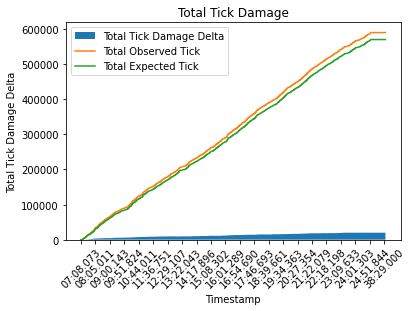

In [41]:
import matplotlib.pyplot as plt

# Extract the last 9 characters from the Timestamp column
df['Short Timestamp'] = df['Timestamp'].str[-9:]

# Plotting the Total Tick Damage Delta as a stacked area chart
plt.stackplot(df.index, df['Total Tick Damage Delta'], labels=['Total Tick Damage Delta'])

# Plot the observed tick and expected tick totals as lines
plt.plot(df.index, df['Total Observed Tick'], label='Total Observed Tick')
plt.plot(df.index, df['Total Expected Tick'], label='Total Expected Tick')

# Set the title and labels for the axes
plt.title('Total Tick Damage')
plt.xlabel('Timestamp')
plt.ylabel('Total Tick Damage Delta')

# Specify the desired tick interval
tick_interval = 100

# Set the x-axis tick locations and labels
plt.xticks(df.index[::tick_interval], df['Short Timestamp'].values[::tick_interval])

# Add a legend
plt.legend()

# Rotate the x-axis labels if needed
plt.xticks(rotation=45)

# Display the plot
plt.show()